# Import libs

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

# Mount Google drive

In [2]:
from google.colab import drive
from google.colab import output

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Change current working directory via "os.chdir"

In [4]:
print(Path.cwd())

/content


In [5]:
os.chdir("/content/drive/MyDrive/casting_product_classification")

In [6]:
path_parent = Path.cwd()
print(path_parent)

/content/drive/MyDrive/casting_product_classification


# Data preperation

In [7]:
train_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

In [8]:
test_generator = ImageDataGenerator(rescale=1.0/255)

In [9]:
image_shape = (300, 300, 1)
batch_size = 32

## Train data

In [10]:
path_train_images = path_parent.joinpath("data/casting_data_300x300/train")

In [11]:
arg_train = {'target_size': image_shape[:2],
             'color_mode': 'grayscale',
             'batch_size': batch_size,
             'class_mode':'binary',
             'shuffle': True}

In [12]:
train_set = train_generator.flow_from_directory(directory=path_train_images, subset='training', **arg_train)
val_set = train_generator.flow_from_directory(directory=path_train_images, subset='validation', **arg_train)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.


In [13]:
print(f"Class mapping: {train_set.class_indices}")
print(f"Number of samples in training set: {train_set.samples}")
print(f"Number of samples in validation set: {val_set.samples}")

Class mapping: {'def_front': 0, 'ok_front': 1}
Number of samples in training set: 4644
Number of samples in validation set: 1989


## Test data

In [14]:
path_test_images = path_parent.joinpath("data/casting_data_300x300/test")

In [15]:
arg_test = {'target_size': image_shape[:2],
            'color_mode': 'grayscale',
            'batch_size': batch_size,
            'class_mode':'binary',
            'shuffle': False}

In [16]:
test_set = test_generator.flow_from_directory(directory=path_test_images, **arg_test)

Found 715 images belonging to 2 classes.


In [17]:
print(f"Class mapping: {test_set.class_indices}")
print(f"Number of samples in test set: {test_set.samples}")

Class mapping: {'def_front': 0, 'ok_front': 1}
Number of samples in test set: 715


# Create model

In [40]:
def create_model():
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())

  # 224 is a good number of unit
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

In [45]:
model = create_model()

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 298, 298, 8)       80        
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 149, 149, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 147, 147, 16)      1168      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 73, 73, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 71, 71, 16)        2320      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 35, 35, 16)       

# Training

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [46]:
history = model.fit(train_set,
                    epochs=20,
                    validation_data=val_set,
                    # steps_per_epoch= train_set.samples,
                    callbacks=[early_stop])

Epoch 1/20
146/146 [==============================] - 23s 143ms/step - loss: 0.5511 - accuracy: 0.7104 - val_loss: 0.4499 - val_accuracy: 0.7582
Epoch 2/20
146/146 [==============================] - 20s 138ms/step - loss: 0.2951 - accuracy: 0.8766 - val_loss: 0.2025 - val_accuracy: 0.9316
Epoch 3/20
146/146 [==============================] - 25s 172ms/step - loss: 0.1599 - accuracy: 0.9444 - val_loss: 0.1583 - val_accuracy: 0.9392
Epoch 4/20
146/146 [==============================] - 20s 135ms/step - loss: 0.1163 - accuracy: 0.9599 - val_loss: 0.0942 - val_accuracy: 0.9789
Epoch 5/20
146/146 [==============================] - 21s 142ms/step - loss: 0.0915 - accuracy: 0.9705 - val_loss: 0.1091 - val_accuracy: 0.9553
Epoch 6/20
146/146 [==============================] - 20s 139ms/step - loss: 0.0788 - accuracy: 0.9748 - val_loss: 0.0917 - val_accuracy: 0.9739
Epoch 7/20
146/146 [==============================] - 27s 184ms/step - loss: 0.0471 - accuracy: 0.9888 - val_loss: 0.0466 - val_ac

In [47]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.551052,0.710379,0.449861,0.758170
1,0.295086,0.876615,0.202545,0.931624
2,0.159906,0.944444,0.158304,0.939165
3,0.116334,0.959948,0.094216,0.978884
4,0.091508,0.970500,0.109062,0.955254


<Axes: >

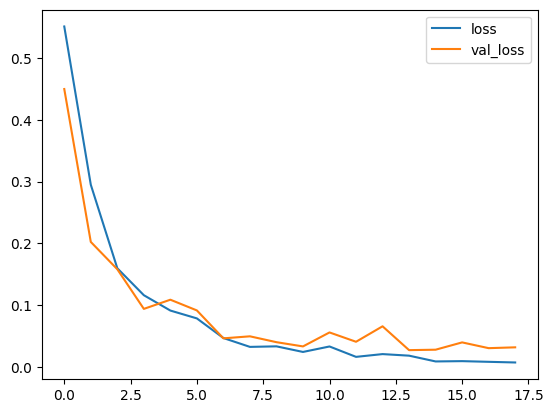

In [48]:
df_history[['loss', 'val_loss']].plot()

In [49]:
print(type(history.history))
print(history.history.keys())

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Axes: >

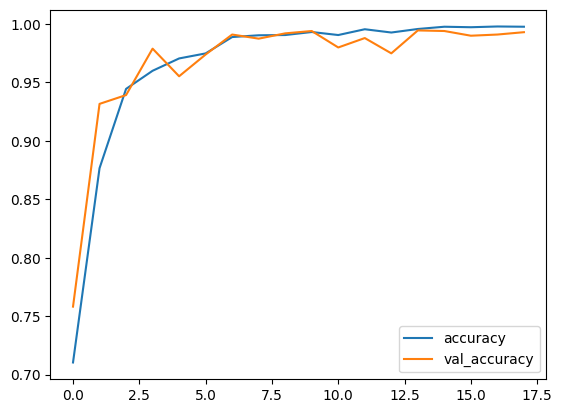

In [50]:
df_history[['accuracy', 'val_accuracy']].plot()

# Analyzing model performance

In [55]:
pred_probability = model.predict(test_set)

23/23 [==============================] - 2s 95ms/step


In [56]:
predictions = pred_probability > 0.5

In [57]:
print(classification_report(y_true=test_set.classes, y_pred=predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       0.99      1.00      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [58]:
print(confusion_matrix(y_true=test_set.classes, y_pred=predictions))

[[450   3]
 [  1 261]]


# Save the trained model

In [59]:
model.save('model_holder/simple_cnn_model.keras')